[1] Loading and processing total volume...
    -> Global binarization complete.
[2] Extracting 10 random ROIs of size 100^3...

--- POROSITY RESULTS PER ROI ---
 ROI Center (Z,Y,X)  Porosity (%)  Relative Error (%)
   1  (230,231,150)         48.47              199.75
   2  (119,452,116)         33.38              106.45
   3   (248,362,93)         33.94              109.87
   4  (196,354,290)         50.83              214.37
   5   (68,300,183)         48.40              199.29
   6  (109,496,373)         48.52              200.03
   7  (228,380,351)         49.66              207.10
   8  (152,186,358)         54.86              239.30
   9   (57,137,194)         46.31              186.38
  10  (224,457,594)         35.66              120.55

Summary Statistics:
-> Mean of 10 ROIs: 45.00%
-> Standard Deviation: 7.71%
-> Helium Reference: 16.17%


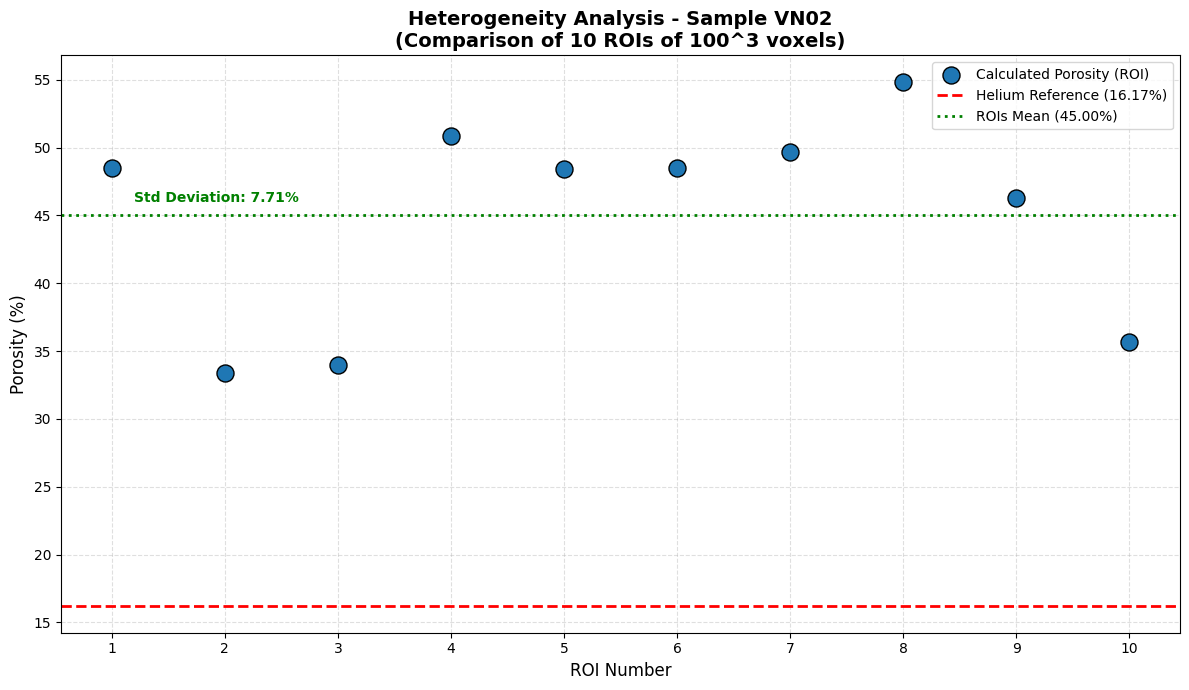


--- END OF AUDIT SCRIPT ---


In [4]:
# =============================================================================
#
# OBJECTIVE:
# Evaluate the spatial variability of porosity across 10 distinct random
# sub-volumes to assess sample heterogeneity and validate segmentation results.
#
# SAMPLE: VN02_AMOSTRA01
# REFERENCE: Helium Porosity (phi_ref) = 16.17%
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import scipy.ndimage as spim
from skimage.filters import threshold_otsu
import random
import gc

# --- CONFIGURATION PARAMETERS ---
FILE_PATH = '/content/drive/MyDrive/pesquisa_mestrado_2025/dados_mestrado/VN02_AMOSTRA01_RECORTADO_300_IMAGENS_40um.tif'
HELIUM_REF_POROSITY = 16.17  # Reference value (%)
CROP_SIDE_LENGTH = 100       # Cube dimensions (100x100x100 voxels)
NUM_SAMPLES = 10             # Number of ROIs for statistical sampling

# --- 1. GLOBAL VOLUME LOADING AND PRE-PROCESSING ---
print("[1] Loading and processing total volume...")
try:
    raw_3d = imageio.volread(FILE_PATH)
    # Apply 3D Median Filter for denoising
    filtered_3d = spim.median_filter(raw_3d, size=3)

    # Calculate global threshold using Otsu's Method
    otsu_threshold = threshold_otsu(filtered_3d)

    # Binarization: Inverting mask so True = Pore (for direct mean calculation)
    binarized_pore_space = ~(filtered_3d > otsu_threshold)

    # Memory Cleanup: release large intermediate arrays
    del raw_3d, filtered_3d
    gc.collect()
    print("    -> Global binarization complete.")

except Exception as e:
    print(f"CRITICAL ERROR during loading/processing: {e}")

# --- 2. RANDOM MULTI-ROI EXTRACTION ---
print(f"[2] Extracting {NUM_SAMPLES} random ROIs of size {CROP_SIDE_LENGTH}^3...")
z_max, y_max, x_max = binarized_pore_space.shape
half_side = CROP_SIDE_LENGTH // 2

roi_results = []

for i in range(NUM_SAMPLES):
    # Randomly select a center coordinate within valid boundaries
    cz = random.randint(half_side, z_max - half_side)
    cy = random.randint(half_side, y_max - half_side)
    cx = random.randint(half_side, x_max - half_side)

    # Sub-volume extraction via slicing
    roi = binarized_pore_space[
        cz - half_side : cz + half_side,
        cy - half_side : cy + half_side,
        cx - half_side : cx + half_side
    ]

    # Calculate ROI porosity and relative error
    calc_porosity = np.mean(roi) * 100
    rel_error = ((calc_porosity - HELIUM_REF_POROSITY) / HELIUM_REF_POROSITY) * 100

    roi_results.append({
        'ROI': i + 1,
        'Center (Z,Y,X)': f"({cz},{cy},{cx})",
        'Porosity (%)': round(calc_porosity, 2),
        'Relative Error (%)': round(rel_error, 2)
    })

# --- 3. DATA TABULATION AND SUMMARY ---
df_results = pd.DataFrame(roi_results)
print("\n--- POROSITY RESULTS PER ROI ---")
print(df_results.to_string(index=False))

# Calculate General Statistics
avg_porosity = df_results['Porosidade (%)'].mean() if 'Porosidade (%)' in df_results else df_results['Porosity (%)'].mean()
std_deviation = df_results['Porosidade (%)'].std() if 'Porosidade (%)' in df_results else df_results['Porosity (%)'].std()

print(f"\nSummary Statistics:")
print(f"-> Mean of 10 ROIs: {avg_porosity:.2f}%")
print(f"-> Standard Deviation: {std_deviation:.2f}%")
print(f"-> Helium Reference: {HELIUM_REF_POROSITY}%")

# --- 4. VISUALIZATION DASHBOARD ---
plt.figure(figsize=(12, 7))

# Plot calculated porosity for each ROI
plt.scatter(df_results['ROI'], df_results['Porosity (%)' if 'Porosity (%)' in df_results else 'Porosidade (%)'],
            color='#1f77b4', s=150, label='Calculated Porosity (ROI)', edgecolors='black', zorder=3)

# Reference Lines
plt.axhline(y=HELIUM_REF_POROSITY, color='red', linestyle='--', linewidth=2,
            label=f'Helium Reference ({HELIUM_REF_POROSITY}%)')
plt.axhline(y=avg_porosity, color='green', linestyle=':', linewidth=2,
            label=f'ROIs Mean ({avg_porosity:.2f}%)')

# Chart Formatting
plt.title(f'Heterogeneity Analysis - Sample VN02\n(Comparison of {NUM_SAMPLES} ROIs of {CROP_SIDE_LENGTH}^3 voxels)',
          fontsize=14, fontweight='bold')
plt.xlabel('ROI Number', fontsize=12)
plt.ylabel('Porosity (%)', fontsize=12)
plt.xticks(range(1, 11))
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(loc='best')

# Annotation for variability
plt.text(1.2, avg_porosity + 1, f'Std Deviation: {std_deviation:.2f}%',
         color='green', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

print("\n--- END OF AUDIT SCRIPT ---")